## Fit Three 2D Gaussians
<div class="alert alert-info">
Goal: To fit Three 2D gaussians to the FOXSI3 SLF data corrected by darks.
<div>

### Import Packages:

In [1]:
from astropy import wcs
from astropy.io import fits as pyfits
from ndcube import NDCube
from astropy.visualization import ImageNormalize, MinMaxInterval, LogStretch, LinearStretch
from astropy.modeling import models, fitting
from mpl_toolkits import mplot3d
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.stats

### Workspace:

#### Fit of the three 2D-gaussians

In [2]:
''' Plate scale '''
distance = 2. * u.m ## FOXSI focal distance
CCD_PIXEL_PITCH = 13.5 * u.micron ## Andor CCD Pitch in microns
binning = 2. ## binning used for collecting data.
plate_scale = np.arctan(binning * CCD_PIXEL_PITCH / distance).to(u.arcsec) ## in arcsec

''' Path to the folder where to find your data and darks: '''
folder = '/Users/Kamilobu/Desktop/Developer/foxsi3_optics_cal/data/'

''' File names: '''
filename = 'kFOXSI3_X10-Test_CCD_T2Sx6_10kV_0p02mA_0mmZ.fits'  ## name of your data fits file.
darkfilename = 'Dark1_FOXSI3_X10-Test_CCD_T2Sx6_10kV_0p02mA_+15mmZ.fits'  ## name of your darks fits file.
## These are fits files containing six frames each of 1024x1024 pixels taken at the SLF
## using the Andor camera and the Mo X-ray source. Voltages,Currents and Integration Times are 
## indicated over the names of the files.

## Read fits files using astropy.io.fits
fits = pyfits.open(folder+filename)
darkfits = pyfits.open(folder+darkfilename)

## Create data array corrected by darks:
data = np.average(fits[0].data, axis=0) - np.average(darkfits[0].data, axis=0)
smax_pixel = np.unravel_index(np.argmax(data), data.shape)
fov = [20, 20] ## [px,px]
sdata = data[smax_pixel[0]-fov[0]:smax_pixel[0]+fov[0],smax_pixel[1]-fov[1]:smax_pixel[1]+fov[1]]/data.max()
max_pixel = np.unravel_index(np.argmax(sdata), sdata.shape)

''' Create the WCS information '''
wcs_dict = {
    'CTYPE1':'HPLT-TAN', ## To use sunpy this needs to be in helioporject coord.
    'CTYPE2':'HPLN-TAN', ## Although strange, it does not affect any of the analysis.
    'CUNIT1':'arcsec',
    'CUNIT2':'arcsec',
    'CDELT1': plate_scale.value, ## Plate scale in arcsec
    'CDELT2': plate_scale.value, ## Plate scale in arcsec
    'CRPIX1':0,
    'CRPIX2':0,
    'CRVAL1': 0,
    'CRVAL2': 0,
    'NAXIS1': sdata.shape[0],
    'NAXIS2': sdata.shape[1]
}
input_wcs = wcs.WCS(wcs_dict)

''' Create NDCube '''
datacube = NDCube(sdata, input_wcs)

''' Definition of Two 2D-Gaussians function '''
@models.custom_model
def ThreeGaussians(x, y,
                 x_mean=0, y_mean=0, theta=0,
                 amp1=0, x1_stddev=0, y1_stddev=0, ## Gauss1 param
                 amp2=0, x2_stddev=0, y2_stddev=0, ## Gauss2 param
                 amp3=0, x3_stddev=0, y3_stddev=0, ## Gauss3 param
                 offset=0): ## offset
    ''' Constrain positive values for the amplitudes '''
    if amp1 < 0:
        amp1 = 1e12
    if amp2 < 0:
        amp2 = 1e12
    if amp3 < 0:
        amp3 = 1e12

    '''Define Sum of Gauss funtions'''
    g1 = models.Gaussian2D(amp1, x_mean, y_mean, x1_stddev, y1_stddev, theta)
    g2 = models.Gaussian2D(amp2, x_mean, y_mean, x2_stddev, y2_stddev, theta)
    g3 = models.Gaussian2D(amp3, x_mean, y_mean, x3_stddev, y3_stddev, theta)
    ''' Defining Offset '''
    oset = models.Const2D(amplitude=offset)
    return g1(x,y) + g2(x,y) + g3(x,y) + oset(x,y)

## Make X,Y,Z data for the TWO 2D-Gaussians:
Xg, Yg = np.mgrid[0:datacube.data.shape[0], 0:datacube.data.shape[1]]

''' Fit Three 2D-Gaussians '''
## Initial Guess :
ThreeG_guess = ThreeGaussians(x_mean=max_pixel[0], y_mean=max_pixel[1], theta=0,
                          amp1 = 0.10111*np.max(datacube.data),
                          amp2 = 0.57882*np.max(datacube.data),
                          amp3 = 0.32008*np.max(datacube.data),
                          x1_stddev=5.0171, y1_stddev=4.0530,
                          x2_stddev=0.6243, y2_stddev=1.2561,
                          x3_stddev=1.5351, y3_stddev=2.2241,offset=0)

## Finding best fit:
fit2DG = fitting.LevMarLSQFitter()
ThreeG_out = fit2DG(ThreeG_guess, Xg, Yg, datacube.data, maxiter=350) ## maxiter keyword is the max number of iterations.
Zout = ThreeG_out(Xg, Yg)

## Individual Gaussian Functions:
g1 = models.Gaussian2D(ThreeG_out.amp1.value, ThreeG_out.x_mean.value, 
                       ThreeG_out.y_mean.value, ThreeG_out.x1_stddev.value, 
                       ThreeG_out.y1_stddev.value, ThreeG_out.theta.value)
g2 = models.Gaussian2D(ThreeG_out.amp2.value, ThreeG_out.x_mean.value, 
                       ThreeG_out.y_mean.value, ThreeG_out.x2_stddev.value, 
                       ThreeG_out.y2_stddev.value, ThreeG_out.theta.value)
g3 = models.Gaussian2D(ThreeG_out.amp3.value, ThreeG_out.x_mean.value, 
                       ThreeG_out.y_mean.value, ThreeG_out.x3_stddev.value, 
                       ThreeG_out.y3_stddev.value, ThreeG_out.theta.value)
### Individual Gaussian Arrays:
G1 = g1(Xg, Yg)
G2 = g2(Xg, Yg)
G3 = g3(Xg, Yg)

''' R^2 function definition '''
## More info: https://en.wikipedia.org/wiki/Coefficient_of_determination
def RSquared(data,model):
    ## The closest to 1, the better is the fit.
    ss_err=(model.fit_info['fvec']**2).sum()
    ss_tot=((data-data.mean())**2).sum()
    return 1-(ss_err/ss_tot)
''' Estimate R^2 '''
RS3G = RSquared(datacube.data, fit2DG)
'''  Chi Square '''
chisq = scipy.stats.chisquare(datacube.data[np.abs(Zout) >= 1e-15], f_exp=Zout[np.abs(Zout) >= 1e-15])

#### Plotting

##### Plot Flat Fitted Gaussians 

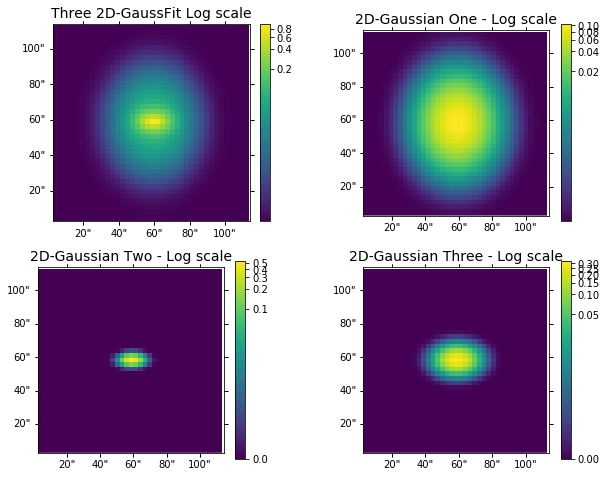

The amplitud ratios for the guessed three 2D-Gaussians are: A1 = 0.10111, A2 = 0.57881, and 0.32008.
The amplitud ratios for the three 2D-Gaussians are: A1 = 0.10900, A2 = 0.55676, and 0.33424.
The standard deviation for the three 2D-Gaussians are: S1x = 4.76974, S1y = 3.88903, S2x = 0.61117, S2y = 1.22390, S3x = 1.45373, and S3y = 2.18298.
Offset = 0.00091
$R^2$ for three gaussians is 0.98653
$chi^2$ for three gaussians is 2.51156


In [3]:
# Create ImageNormalize objects:
normLogT = ImageNormalize(Zout, interval=MinMaxInterval(),stretch=LogStretch())
normLog1 = ImageNormalize(G1, interval=MinMaxInterval(),stretch=LogStretch())
normLog2 = ImageNormalize(G2, interval=MinMaxInterval(),stretch=LogStretch())
normLog3 = ImageNormalize(G3, interval=MinMaxInterval(),stretch=LogStretch())

''' Plotting '''
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(10,8),
                                             subplot_kw=dict(projection=datacube.wcs))
fig.subplots_adjust(wspace = 0.4) ## Sets space between subplots to avoid overlap
## Best fit of the all three gaussians:
im1 = ax1.imshow(Zout, origin='lower', cmap=plt.cm.viridis,norm=normLogT)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_title('Three 2D-GaussFit Log scale',fontsize=14)
## Gaussian One:
im2 = ax2.imshow(G1, origin='lower', cmap=plt.cm.viridis,norm=normLog1)
cbar2 = fig.colorbar(im2,ax=ax2)
ax2.set_title('2D-Gaussian One - Log scale',fontsize=14)
## Gaussian Two:
im3 = ax3.imshow(G2, origin='lower', cmap=plt.cm.viridis,norm=normLog2)
cbar3 = fig.colorbar(im3,ax=ax3)
ax3.set_title('2D-Gaussian Two - Log scale',fontsize=14)
## Gaussian Two:
im4 = ax4.imshow(G3, origin='lower', cmap=plt.cm.viridis,norm=normLog3)
cbar4 = fig.colorbar(im4,ax=ax4)
ax4.set_title('2D-Gaussian Three - Log scale',fontsize=14)
plt.show()

''' Print what the amplitud ratios are '''
print('The amplitud ratios for the guessed three 2D-Gaussians are: A1 = {0:.5f}, A2 = {1:.5f}, and {2:.5f}.'
      .format(round(ThreeG_guess.amp1.value/(ThreeG_guess.amp1.value+ThreeG_guess.amp2.value+ThreeG_guess.amp3.value),5),
              round(ThreeG_guess.amp2.value/(ThreeG_guess.amp1.value+ThreeG_guess.amp2.value+ThreeG_guess.amp3.value),5),
              round(ThreeG_guess.amp3.value/(ThreeG_guess.amp1.value+ThreeG_guess.amp2.value+ThreeG_guess.amp3.value),5),
       ))
print('The amplitud ratios for the three 2D-Gaussians are: A1 = {0:.5f}, A2 = {1:.5f}, and {2:.5f}.'
      .format(round(ThreeG_out.amp1.value/(ThreeG_out.amp1.value+ThreeG_out.amp2.value+ThreeG_out.amp3.value),5),
              round(ThreeG_out.amp2.value/(ThreeG_out.amp1.value+ThreeG_out.amp2.value+ThreeG_out.amp3.value),5),
              round(ThreeG_out.amp3.value/(ThreeG_out.amp1.value+ThreeG_out.amp2.value+ThreeG_out.amp3.value),5),
       ))
print('The standard deviation for the three 2D-Gaussians are: S1x = {0:.5f}, S1y = {1:.5f}, S2x = {2:.5f}, S2y = {3:.5f}, S3x = {4:.5f}, and S3y = {5:.5f}.'
      .format(round(ThreeG_out.x1_stddev.value,5),
              round(ThreeG_out.y1_stddev.value,5),
              round(ThreeG_out.x2_stddev.value,5),
              round(ThreeG_out.y2_stddev.value,5),
              round(ThreeG_out.x3_stddev.value,5),
              round(ThreeG_out.y3_stddev.value,5),
       ))
print('Offset = {0:.5f}'.format(round(ThreeG_out.offset.value,5)))
print('$R^2$ for three gaussians is {0:.5f}'.format(round(RS3G,5)))
print('$chi^2$ for three gaussians is {0:.5f}'.format(round(chisq[0],5)))

##### Plot  3D Fitted Gaussians

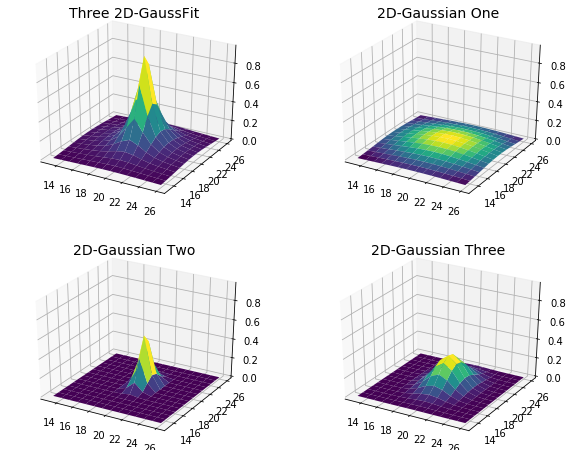

In [4]:
''' Clipping data '''
fov = [7,7]
sXg = Xg[max_pixel[0]-fov[0]:max_pixel[0]+fov[0],max_pixel[1]-fov[1]:max_pixel[1]+fov[1]]
sYg = Yg[max_pixel[0]-fov[0]:max_pixel[0]+fov[0],max_pixel[1]-fov[1]:max_pixel[1]+fov[1]]
sZout = ThreeG_out(sXg, sYg)
sG1 = g1(sXg, sYg)
sG2 = g2(sXg, sYg)
sG3 = g3(sXg, sYg)

''' 3D plotting '''
## Uncomment this line if you want interactivity
#%matplotlib notebook
%matplotlib inline

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(10,8),
                                             subplot_kw=dict(projection='3d'))
ax1.plot_surface(sXg,sYg,sZout,cmap=plt.cm.viridis)
ax1.set_title('Three 2D-GaussFit',fontsize=14)
ax1.set_zlim3d(0, sZout.max())
ax2.plot_surface(sXg,sYg,sG1,cmap=plt.cm.viridis)
ax2.set_title('2D-Gaussian One',fontsize=14)
ax2.set_zlim3d(0, sZout.max())
ax3.plot_surface(sXg,sYg,sG2,cmap=plt.cm.viridis)
ax3.set_title('2D-Gaussian Two',fontsize=14)
ax3.set_zlim3d(0, sZout.max())
ax4.plot_surface(sXg,sYg,sG3,cmap=plt.cm.viridis)
ax4.set_title('2D-Gaussian Three',fontsize=14)
ax4.set_zlim3d(0, sZout.max())
plt.show()

##### Plot Difference Data vs Fit

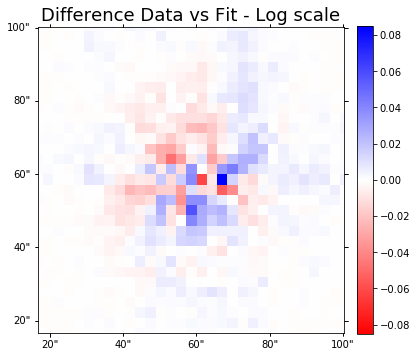

In [5]:
diff = (datacube.data-Zout)
diffmax = (np.array(diff.max(),-diff.min())).max()
fov = [15,15]
fig, ax1 = plt.subplots(figsize=(6,6),subplot_kw=dict(projection=datacube.wcs))
im1 = ax1.imshow(datacube.data-Zout, origin='lower', cmap=plt.cm.bwr_r,vmin=-diffmax,vmax=diffmax)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_xlim(max_pixel[1]-fov[1], max_pixel[1]+fov[1])
ax1.set_ylim(max_pixel[0]-fov[0], max_pixel[0]+fov[0])
ax1.set_title('Difference Data vs Fit - Log scale',fontsize=18)
plt.show()